In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')

In [2]:
# df = pd.read_csv('weekly_dmd.csv')
df = pd.read_csv('weekly_dmd_new.csv')
df['date'] = pd.to_datetime(df.date).apply(lambda x: x.date())
df = df.set_index(df.date)
df.index.rename('date_idx', inplace=True)
df.head(2)

,zone_id,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,total_demand_new_lag3,total_demand_new_lag-1,total_demand_new_lag-2,total_demand_new_lag-3,smoothed_total_demand,year,total_demand_new_lag4,t4w_total_demand,month,week,day,t4w_total_demand_lag2,szn_factor
date_idx,,,,,,,,,,,,,,,,,,
2017-06-26,1,2017-06-26,1900.84505,NaN,NaN,NaN,2155.673157,2193.532475,2110.494687,NaN,2017,NaN,NaN,6,26,26,NaN,NaN
2017-06-26,970,2017-06-26,0.00000,NaN,NaN,NaN,0.000000,0.000000,0.000000,NaN,2017,NaN,NaN,6,26,26,NaN,NaN


In [26]:
def set_lag_features(df, col, lags):
    """lags: array of desired lags to compute"""
    
    df.sort_values('date', ascending=True, inplace=True)
    
    for lag in lags:
        df[f'{col}_lag{lag}'] = df.groupby('zone_id')[col].shift(lag)
        
    return df

In [27]:
response = 'total_demand'
df = set_lag_features(df, f'{response}_new', [5,6,7])

<ipython-input-1205-29803c084a1b>:7: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  warnings.warn('No frequency information was'
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:1112: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  warnings.warn(
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwint

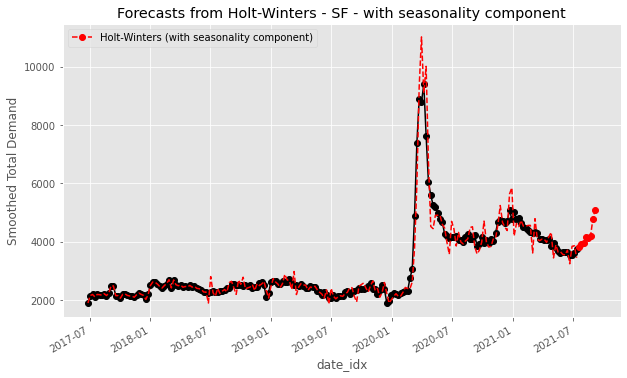

In [1205]:
### Out of the box holt-winters model to compare with below "modified" holt-winters implementation that handles covid

zdf = df1.sort_values('date').total_demand_new.astype(float)

fit1 = ExponentialSmoothing(zdf, trend='add', seasonal='mul',
                            seasonal_periods=52,
                            damped=False
                           ).fit(optimized=True, use_boxcox=False)

ax = zdf.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters - SF - with seasonality component" )
ax.set_ylabel("Smoothed Total Demand")
ax.set_xlabel("Week")
fit1.fittedvalues.plot(ax=ax, style='--', color='red')

fit1.forecast(8).rename('Holt-Winters (with seasonality component)').plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()

In [1206]:
fit1.params

{'smoothing_level': 0.8889285714285714,
 'smoothing_trend': 0.8230820105820106,
 'smoothing_seasonal': 0.1110714285714286,
 'damping_trend': nan,
 'initial_level': 2783.5069797410138,
 'initial_trend': 2.386143219742208,
 'initial_seasons': array([0.68289574, 0.77444503, 0.78804634, 0.75821426, 0.7884416 ,
        0.78535444, 0.7800498 , 0.79779579, 0.77496207, 0.8049305 ,
        0.89501213, 0.8930455 , 0.7739801 , 0.7729854 , 0.74207211,
        0.78991075, 0.79566146, 0.77662844, 0.76978372, 0.76735162,
        0.75392567, 0.78446413, 0.80469954, 0.78912728, 0.77667462,
        0.72745409, 0.78769021, 0.90074226, 0.94180849, 0.93834758,
        0.91596839, 0.88651684, 0.86766494, 0.89792067, 0.92251673,
        0.97017268, 0.86870371, 0.9664977 , 0.90869349, 0.89537723,
        0.90601365, 0.87712368, 0.88626101, 0.88056957, 0.89936271,
        0.87801349, 0.88820917, 0.86324305, 0.8591175 , 0.84884055,
        0.8179303 , 0.81807011]),
 'use_boxcox': False,
 'lamda': None,
 'remove

<AxesSubplot:>

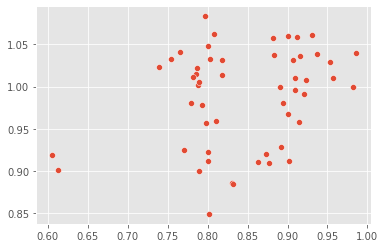

In [165]:
sns.scatterplot(x=fit1.params['initial_seasons'], y=map_estimate['initial_szns'])

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/results.py:169: FutureWarning: slope is deprecated and will be removed after 0.13
  warnings.warn(


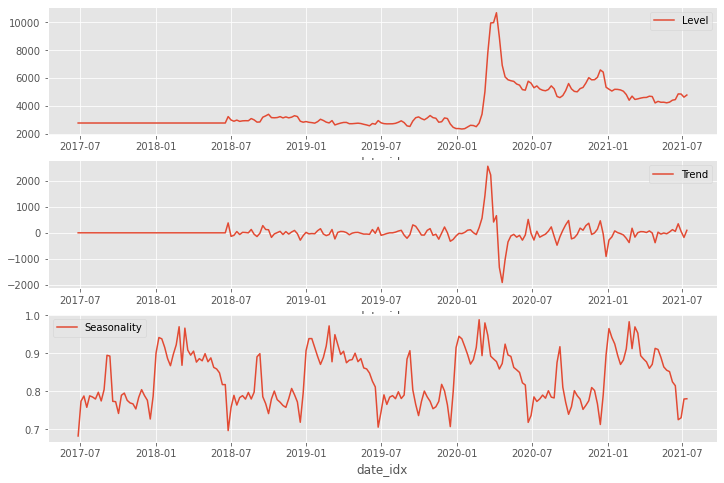

In [1207]:
states1 = pd.DataFrame(np.c_[fit1.level, fit1.slope, fit1.season, fit1.fittedvalues], columns=['level','slope','seasonal', 'fitted_val'], index=zdf.index)

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(12,8))
states1.level.plot(ax=ax1, label='Level')
states1.slope.plot(ax=ax2, label='Trend')
states1.seasonal.plot(ax=ax3, label='Seasonality')

ax1.legend(loc='best')
ax2.legend(loc='best')
ax3.legend(loc='best')

##### Start adding dampener

In [122]:
# [X] dampening
# [] fit on horizon-steps ahead

def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if False: # force using seasonal estimates
#         if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    
        trend_dampener = pm.Uniform('trend_dampener', lower=0, upper=1)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + trend_dampener*prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + trend_dampener*prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*trend_dampener*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [123]:
# [] dampening
# [] fit on horizon-steps ahead

def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + map_estimate['trend_dampener']*prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + map_estimate['trend_dampener']*prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*map_estimate['trend_dampener']*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
#     pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
    trend_multiplier = np.sum([map_estimate['trend_dampener']**i for i in range(1,horizon+1)])
    pred = (levels.get_test_value()[-1] + trend_multiplier*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [163]:
# [X] dampening
# [...] fit on horizon-steps ahead
n_steps_ahead = 5

def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if False: # force using seasonal estimates
#         if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
#         is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m5'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    
        trend_dampener = pm.Uniform('trend_dampener', lower=0, upper=1)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + trend_dampener*prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + trend_dampener*prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*trend_dampener*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


#         levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
#         trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])
        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-n_steps_ahead]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-n_steps_ahead]])
#         seasons_f = pm.math.concatenate([initial_szns, seasons[n_steps_ahead - 1:-(szn_len + n_steps_ahead - 1)]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[n_steps_ahead - 1:-szn_len]])
        
        trends_and_dampener = trends_f * pm.math.sum([trend_dampener**i for i in range(1,n_steps_ahead+1)])

#         levels_and_trends = pm.math.stack([levels_f, trends_f])
        levels_and_trends = pm.math.stack([levels_f, trends_and_dampener])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[1:, :]['y_obs'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[n_steps_ahead:, :]['y_obs'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [164]:
# [] dampening
# [] fit on horizon-steps ahead
n_steps_ahead = 5

def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + map_estimate['trend_dampener']*prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + map_estimate['trend_dampener']*prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*map_estimate['trend_dampener']*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

#     levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
#     trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
# #     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
#     seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])
    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-n_steps_ahead]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-n_steps_ahead]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
#     seasons_f = pm.math.concatenate([szn_estimates, seasons[n_steps_ahead - 1:-(szn_len + n_steps_ahead - 1)]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[n_steps_ahead - 1:-szn_len]])
    
    trends_and_dampener = trends_f * pm.math.sum([map_estimate['trend_dampener']**i for i in range(1,n_steps_ahead+1)])

#     levels_and_trends = pm.math.stack([levels_f, trends_f])
    levels_and_trends = pm.math.stack([levels_f, trends_and_dampener])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    # this -1 seems to make sense given that first initial_szn corresponds to Y1
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
#     pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
    trend_multiplier = np.sum([map_estimate['trend_dampener']**i for i in range(1,horizon+1)])
    pred = (levels.get_test_value()[-1] + trend_multiplier*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

##### End adding dampener

In [84]:
def fit_hw_model(zdf, initial_lvl_upper):
    szn_len = 52

    with pm.Model() as hw_model:
    #     initial_level = pm.Normal(f'initial_level', mu=3000, sigma=400)
#         initial_level = pm.Uniform(f'initial_level', lower=0, upper=5000)
        initial_level = pm.Uniform(f'initial_level', lower=0, upper=initial_lvl_upper)
        smoothing_level = pm.Uniform('smoothing_level', lower=0, upper=1)
#         smoothing_level = pm.Normal('smoothing_level', mu=0.5, sigma=0.5)

    #     initial_trend = pm.Normal(f'initial_trend', mu=0, sigma=100)
#         initial_trend = pm.Uniform(f'initial_trend', lower=-1000, upper=1000)
        initial_trend = pm.Uniform(f'initial_trend', lower=-initial_lvl_upper/2, upper=initial_lvl_upper/2)
#         smoothing_trend = pm.Uniform('smoothing_trend', lower=0, upper=1)
        smoothing_trend = pm.Uniform('smoothing_trend', lower=0.15, upper=1)
    #     smoothing_trend = pm.Normal('smoothing_trend', mu=0.5, sigma=0.5)

        if len(zdf) < 115:
#         if len(zdf) < szn_len*2.5:
#         if len(zdf) < szn_len*2:
#             initial_szns = pm.Deterministic('initial_szns', 1.0, dims=(szn_len))
            initial_szns = tt.as_tensor_variable([1.0 for i in range(52)])
            smoothing_season = 0.0
#             smoothing_season = pm.Deterministic('smoothing_season', 1.0)
        else:
            initial_szns = pm.Normal('initial_szns', mu=1.0, sigma=0.2, shape=(szn_len))
        #     initial_szns = pm.Uniform('initial_szns', lower=0.7, upper=1.3, shape=(szn_len))
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1)
        #     smoothing_season = pm.Uniform('smoothing_season', lower=0, upper=1-smoothing_level)
            smoothing_season = pm.TruncatedNormal('smoothing_season', mu=0.2, sigma=0.5, lower=0, upper=0.8)
        #     smoothing_season = pm.Normal('smoothing_season', mu=0.5, sigma=0.5)

        ys = tt.as_tensor_variable(zdf['y_obs'])
        is_covid_start = tt.as_tensor_variable(zdf['covid_start_m1'])
    #     covid_level_change = pm.Normal('covid_level_change', mu=15000, sigma=2000)
        covid_level_change = pm.Uniform('covid_level_change', lower=0, upper=5000)
#         covid_level_change = pm.Normal('covid_level_change', mu=2000, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=20000, sigma=2000)
#         covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=5000)
        covid_level_change2 = pm.Uniform('covid_level_change2', lower=0, upper=10000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)
    #     covid_level_change2 = pm.Normal('covid_level_change2', mu=covid_level_change, sigma=1000)

        def hw_component_wise(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = smoothing_season * y / (prior_level + prior_trend) + (1 - smoothing_season) * szn_m52


            next_level = smoothing_level * (y/szn_m52) + (1 - smoothing_level)*(prior_level + prior_trend) + covid_start*covid_level_change
            next_trend = smoothing_trend * (next_level - prior_level) + (1 - smoothing_trend)*prior_trend - covid_start*smoothing_trend*covid_level_change2


            return next_level, next_trend, updated_szn

        outputs, updates = theano.scan(hw_component_wise,
               sequences = [
                   ys[1:],
#                    ys[szn_len:],
                   is_covid_start[1:]
#                    is_covid_start[szn_len:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = initial_level, taps=None),
                   dict(initial = initial_trend, taps=None),
                   dict(initial = initial_szns, taps=[-szn_len])
               ], 
        #            non_sequences = 
               )


        levels = outputs[0]
        trends = outputs[1]
        seasons = outputs[2]


        levels_f = pm.math.concatenate([initial_level.reshape(1,1), levels[:-1]])
        trends_f = pm.math.concatenate([initial_trend.reshape(1,1), trends[:-1]])
        seasons_f = pm.math.concatenate([initial_szns, seasons[:-szn_len]])

        levels_and_trends = pm.math.stack([levels_f, trends_f])
        level_plus_trend = levels_and_trends.sum(axis=0)

        level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
        y_hats = level_plus_trend_and_seasons.prod(axis=0)

        sig = pm.HalfCauchy('sigma', beta=10)
#         y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[szn_len-1:-1, :]['y_obs_lag-1'])
        y_like = pm.Normal('y_like', mu=y_hats, sigma=sig, observed=zdf.iloc[:-1, :]['y_obs_lag-1'])
        
    map_estimate = pm.find_MAP(model=hw_model)
    
    return map_estimate, ys, is_covid_start

In [85]:
def predict(map_estimate, ys, is_covid_start, horizon):
    
    if 'initial_szns' in map_estimate:
        szn_estimates = tt.as_tensor_variable(map_estimate['initial_szns'])
        szn_smoother = map_estimate['smoothing_season']
    else:
        szn_estimates = tt.as_tensor_variable([1.0 for i in range(52)])
        szn_smoother = 0.0

    def hw_component_wise_final(y, covid_start, prior_level, prior_trend, szn_m52):
            updated_szn = szn_smoother * y / (prior_level + prior_trend) + (1 - szn_smoother) * szn_m52
#             updated_szn = map_estimate['smoothing_season'] * y / (prior_level + prior_trend) + (1 - map_estimate['smoothing_season']) * szn_m52


            next_level = map_estimate['smoothing_level'] * (y/szn_m52) + (1 - map_estimate['smoothing_level'])*(prior_level + prior_trend) + covid_start*map_estimate['covid_level_change']
            next_trend = map_estimate['smoothing_trend'] * (next_level - prior_level) + (1 - map_estimate['smoothing_trend'])*prior_trend - covid_start*map_estimate['smoothing_trend']*map_estimate['covid_level_change2']


            return next_level, next_trend, updated_szn

    outputs, updates = theano.scan(hw_component_wise_final,
               sequences = [
#                    ys[szn_len:],
                   ys[1:],
#                    is_covid_start[szn_len:]
                   is_covid_start[1:]
        #            post_covid[szn_len:]
               ],
               outputs_info = [
                   dict(initial = map_estimate['initial_level'], taps=None),
                   dict(initial = map_estimate['initial_trend'], taps=None),
                   dict(initial = szn_estimates, taps=[-szn_len])
#                    dict(initial = tt.as_tensor_variable(map_estimate['initial_szns']), taps=[-szn_len])
               ], 
        #            non_sequences = 
               )
    
    levels = outputs[0]
    trends = outputs[1]
    seasons = outputs[2]

    levels_f = pm.math.concatenate([map_estimate['initial_level'].reshape(1), levels[:-1]])
    trends_f = pm.math.concatenate([map_estimate['initial_trend'].reshape(1), trends[:-1]])
#     seasons_f = pm.math.concatenate([map_estimate['initial_szns'], seasons[:-szn_len]])
    seasons_f = pm.math.concatenate([szn_estimates, seasons[:-szn_len]])

    levels_and_trends = pm.math.stack([levels_f, trends_f])
    level_plus_trend = levels_and_trends.sum(axis=0)

    level_plus_trend_and_seasons = pm.math.stack([level_plus_trend, seasons_f])
    y_hats = level_plus_trend_and_seasons.prod(axis=0)
    
    corresponding_szn_idx = (horizon - szn_len) - 1
#     szn_estimate = seasons_f.get_test_value()[corresponding_szn_idx]
    szn_estimate = seasons.get_test_value()[corresponding_szn_idx]

#     pred = (levels_f.get_test_value()[-1] + horizon*trends_f.get_test_value()[-1])*szn_estimate
    pred = (levels.get_test_value()[-1] + horizon*trends.get_test_value()[-1])*szn_estimate
#     return pred, levels, trends, seasons, corresponding_szn_idx, szn_estimate, y_hats
    return pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, y_hats

In [5]:
F_DATE = date(2021,6,7)
# test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(110)]
test_f_dates = [F_DATE - timedelta(weeks=i) for i in range(80)]

In [162]:
covid_start_idx = date(2020,2,17)

df_prep = df.loc[(df.date < covid_start_idx)
                | (df.date >= covid_start_idx + timedelta(weeks=52))].sort_values('date')

df_prep['y_obs'] = df_prep.total_demand_new
# df_prep['y_obs'] = df_prep.smoothed_total_demand
df_prep['covid_start_m1'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=1) else 0)
df_prep['covid_start_m5'] = df_prep.date.apply(lambda x: 1.0 if x == covid_start_idx - timedelta(weeks=5) else 0)

In [10]:
len(test_f_dates)

80

In [9]:
test_dates2 = test_f_dates[:10:3] + test_f_dates[-7::3]
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [7]:
recent_dmd_by_zone = df.loc[df.date >= date(2021,3,1)].groupby('zone_id').total_demand_new.sum().reset_index()
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(2)

,zone_id,total_demand_new
403,785,190316.615898
437,942,166977.068545


In [8]:
zz = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).head(20).zone_id.tolist()
zz2 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[20:30].zone_id.tolist()
zz3 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[30:50].zone_id.tolist()
zz4 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[50:70].zone_id.tolist()
zz5 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[70:90].zone_id.tolist()

zz_top90 = recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].zone_id.tolist()

In [1040]:
recent_dmd_by_zone.sort_values('total_demand_new', ascending=False).iloc[:90].total_demand_new.sum()

4523816.334892994

In [1046]:
df_prep.zone_id.nunique(), HORIZON

(475, 2)

In [ ]:
# res4_1p is zz5 + zz

In [968]:
test_dates2

[datetime.date(2021, 6, 7),
 datetime.date(2021, 5, 17),
 datetime.date(2021, 4, 26),
 datetime.date(2021, 4, 5),
 datetime.date(2020, 1, 13),
 datetime.date(2019, 12, 23),
 datetime.date(2019, 12, 2)]

In [12]:
HORIZON

NameError: name 'HORIZON' is not defined

In [1168]:
df_prep.date.max() - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [1235]:
date(2021,7,12) - timedelta(weeks=2)

datetime.date(2021, 6, 28)

In [7]:
exp_zones = [ 785,  942,  972,  861,  973,  943,  975,  981, 1002,  974,  983,
       1001,  839,  714,    1,  783,  989,  787,   79,  945,  946,  980,
        786,  183,   27,  979,  131,   33,  392,   87,   43,   16,  982,
        713,  988,  262,  840,  144,  709,  181,  204,  440,  225,  245,
        185,  104,  182,  439,  103,  169,   50,  186,   37,  620,  441,
         76,  184,   32,  530,  357,  477,  616,  617,  167,  437,  166,
         38, 1029,   18,  428,  307,  853,  438,  541,  266,   90,  272,
        348,  475,  178,  273,  495,  692,  521,  228,  161,  190,  168,
        694,  707]

In [17]:
date(2021,6,21) - timedelta(weeks=5)

datetime.date(2021, 5, 17)

In [165]:
### walk-forward validation
# HORIZON = 2 # (ie 15-21 days out) compare to TARGET_lag3
HORIZON = 5 # (ie 36-42 days out) compare to TARGET_lag6
szn_len = 52

idx_outer = 1
pred_for_dates, zone_ids, preds, smoothing_levels, smoothing_trends, smoothing_seasons = [], [], [], [], [], []
# for f_date in test_dates2[1:2]:
# for f_date in test_dates2[0:1]:
# for f_date in test_dates2:
# for f_date in [date(2020,1,27)-timedelta(weeks=HORIZON)]:
# for f_date in test_dates2[0:1]:
# for f_date in [date(2021,6,21), date(2021,5,17), date(2021,4,26), date(2021,4,5)]:
for f_date in [date(2021,4,5)]:
# for f_date in [date(2021,6,28), date(2021,7,19)]:
# for f_date in [date(2021,4,26)]:
# for f_date in [date(2021,6,28)]:
# for f_date in [date(2021,7,19)]:
# for f_date in [date(2021,7,26)]:
# for f_date in [date(2021,8,2)]:
# for f_date in [date(2019,12,2)]:
# for f_date in test_f_dates[:5]:
    print(f'iter {idx_outer}/{len(test_dates2)}')
    idx_outer += 1
    
    idx_inner = 1
#     for z_id in zz4[1:]:
#     for z_id in zz5 + zz:
#     for z_id in zz4:
#     for z_id in zz3:
#     for z_id in zz2:
#     for z_id in zz:
#     for z_id in exp_zones:
#     for z_id in zz_top90:
    for z_id in [1]:
#     for z_id in [874]:
#     for z_id in df_prep.zone_id.unique():
#     for z_id in [1001, 943, 787]:
#     for z_id in [1435]:
#     for z_id in [18]:
#     for z_id in [1,973,13]:
#     for z_id in [1,973,13,785,979,1001,972,942,18,27]:

        print(f'inner iter {idx_inner}')
        
#         third_week = df_prep.loc[df_prep.zone_id == z_id].date.unique()[2]
        zdf = df_prep.loc[(df_prep.zone_id == z_id)
                            & (df_prep.date < f_date)
#                             & (df_prep.date > third_week)
                            & (df_prep['y_obs'] > 0)
                           ]
    
        third_week = zdf.date.unique()[2]
        zdf = zdf.loc[zdf.date > third_week]
        
        
        pad_df = pd.DataFrame(columns = zdf.columns)
        pad_df.loc[0, 'zone_id'] = z_id
        zdf = pd.concat([pad_df, zdf])
        
        zdf['y_obs_lag-1'] = zdf.y_obs.shift(-1)
        initial_lvl_upper = zdf.head()['y_obs_lag-1'].max()
        
        
#         if len(zdf) < 104:
#             break
            
        map_estimate, ys, is_covid_start = fit_hw_model(zdf, initial_lvl_upper)
        pred, levels_f, trends_f, seasons_f, seasons, corresponding_szn_idx, szn_estimate, yhats = predict(map_estimate, ys, is_covid_start, HORIZON+1)
        
        pred_for_date = f_date + timedelta(weeks=HORIZON)
        
        pred_for_dates.append(pred_for_date)
        zone_ids.append(z_id)
        preds.append(pred)
        smoothing_levels.append(map_estimate['smoothing_level'])
        smoothing_trends.append(map_estimate['smoothing_trend'])
        if 'smoothing_season' in map_estimate:
            smoothing_seasons.append(map_estimate['smoothing_season'])
        else:
            smoothing_seasons.append(0.0)
        idx_inner += 1
        
res_2 = pd.DataFrame({'pred_for_date': pred_for_dates,
                        'zone_id': zone_ids,
                        'pred': preds,
                        'smoothing_level': smoothing_levels,
                        'smoothing_trend': smoothing_trends,
                        'smoothing_season': smoothing_seasons})

res_2.pred_for_date = pd.to_datetime(res_2.pred_for_date)

iter 1/7
inner iter 1


WARNING (theano.scan.basic): Output initial_level (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output initial_trend (index 1) has a initial state but taps is explicitly set to None 


WARNING (theano.scan.basic): Output None (index 0) has a initial state but taps is explicitly set to None 
WARNING (theano.scan.basic): Output None (index 1) has a initial state but taps is explicitly set to None 


In [ ]:
# see why 979 got so much worse with dampening
    # w/ dampening, it was much more variable - ie smoothing_trend changed drastically
    # maybe with seasonality it wouldn't be the case
    
# are the zones w/o seasonality much less accurate here?

In [143]:
pred, szn_estimate

(4033.230570528075, 1.0139006576264722)

In [166]:
pred, szn_estimate

(3852.930062656931, 0.988151000345881)

In [98]:
res1.shape

(40, 6)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pred', ylabel='Density'>

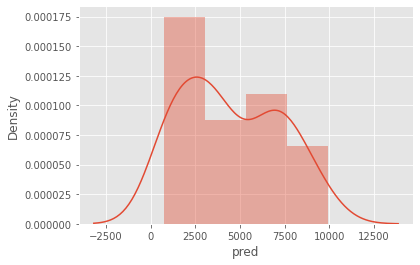

In [21]:
sns.distplot(res1.pred)

In [96]:
# res1.to_csv('./demand_fcast_fdate_08_02_21_new.csv', index=None)

# res1.to_csv('./demand_fcast_fdate_08_02_21.csv', index=None)
# res1.to_csv('./demand_fcast_fdate_07_26_21.csv', index=None)
# res1.to_csv('./demand_fcast_fdate_06_28_21.csv', index=None)

# res1.to_csv('./demand_fcast_fdate_07_19_21.csv', index=None)

In [144]:
map_estimate

{'initial_level_interval__': array(5.96677499),
 'smoothing_level_interval__': array(0.72222608),
 'initial_trend_interval__': array(1.06949318),
 'smoothing_trend_interval__': array(3.08462936),
 'initial_szns': array([0.92214718, 0.93904884, 0.94613427, 0.94209277, 0.97166735,
        0.97770436, 0.9747578 , 1.03819535, 1.04483714, 0.99387068,
        1.00861682, 0.99036258, 1.00186471, 1.01560978, 1.00806357,
        1.02526874, 0.98317812, 0.98193921, 0.97052879, 1.01876708,
        1.04137838, 0.99948619, 0.85332905, 0.91069275, 1.03573057,
        1.06774475, 1.05725327, 1.03048421, 1.02974517, 1.04196327,
        1.05263549, 1.06834585, 1.08971221, 1.04925477, 1.07188148,
        1.05479137, 1.02009891, 1.02891635, 1.0021259 , 0.99690712,
        0.99756085, 1.02372263, 1.00509667, 1.0139012 , 0.97885587,
        0.96995657, 0.95066789, 0.95089249, 0.93679949, 0.9129632 ,
        0.91607833, 0.94221882]),
 'smoothing_season_interval__': array(-9.2765632),
 'covid_level_change_in

In [167]:
map_estimate

{'initial_level_interval__': array(8.40040914),
 'smoothing_level_interval__': array(-2.76658847),
 'initial_trend_interval__': array(3.98736801),
 'smoothing_trend_interval__': array(-1.64427728),
 'initial_szns': array([0.90593243, 0.90740506, 0.9279562 , 0.98409434, 0.99943633,
        0.97046878, 0.95838933, 0.97422353, 0.99911917, 0.99975959,
        1.00735757, 0.99918814, 0.99366246, 0.99887341, 1.01041447,
        1.03703236, 0.99277672, 0.9899544 , 0.94459288, 1.00150184,
        1.07089021, 1.05210348, 0.92933671, 0.95513754, 1.02258665,
        1.03110603, 1.03185461, 1.02768378, 1.06166888, 1.04377323,
        1.07998205, 1.04331094, 1.05999126, 1.06293055, 1.07106241,
        1.08398121, 1.04665253, 1.05399328, 1.02668724, 1.02201057,
        1.0114563 , 1.0221132 , 1.00597378, 0.98814803, 0.96326176,
        0.94738419, 0.92990639, 0.95180971, 0.93169053, 0.90891425,
        0.91745594, 0.92920065]),
 'smoothing_season_interval__': array(-9.8419297),
 'covid_level_change_

In [ ]:
# seems like covid_level_change2 is being used to allow the model to suddenly switch to a -ve trend in post-covid times
# maybe that's not bad though?

# forcing min of .15 for smoothing_trend looks better...
# but still need dampening for this case

# [X] try dampening w/o the .15 min for smoothing_trend
# [] try dampening w/ the .15 min for smoothing_trend

# parameter estimtes w/ the dampener look great

In [66]:
zdf.iloc[1:].reset_index().y_obs

0       624.273423
1       612.904018
2       598.826837
3       611.507891
4       597.768642
          ...     
137    1508.151295
138    1434.620766
139    1514.658421
140    1414.356378
141    1446.099833
Name: y_obs, Length: 142, dtype: float64

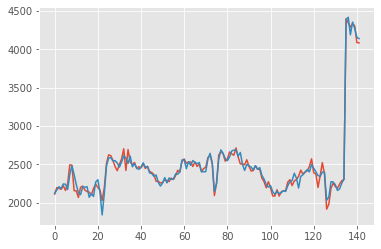

In [145]:
# 1
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

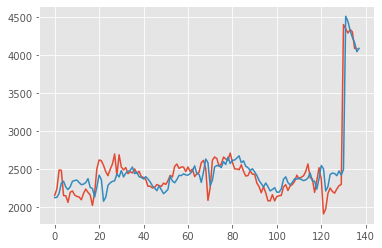

In [169]:
# 1 - fit on n_steps_ahead = 5
zdf.iloc[1+n_steps_ahead:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

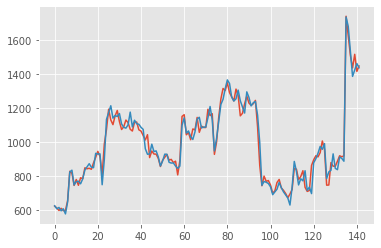

In [89]:
# 18
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

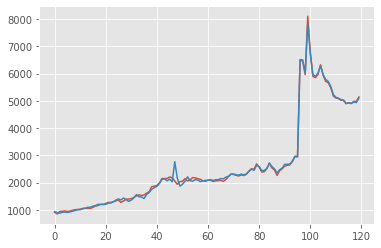

In [70]:
# Denver
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

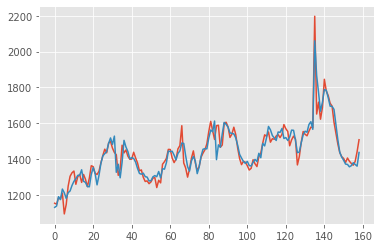

In [39]:
# Austin
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

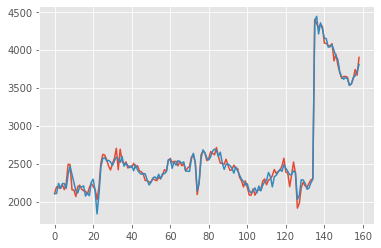

In [15]:
# SF
zdf.iloc[1:].reset_index().y_obs.plot()
plt.plot(yhats.get_test_value())

In [68]:
all_season_estimates = map_estimate['initial_szns'].tolist() + seasons.get_test_value().tolist()

corresponding_dates = zdf.iloc[1:].date.tolist()
for i in range(szn_len):
    corresponding_dates += [corresponding_dates[-1] + timedelta(weeks=1)]

szn_estimates_w_dates = pd.DataFrame(list(zip(all_season_estimates, corresponding_dates)), columns=['szn_estimate', 'date'])

szn_estimates_w_dates = szn_estimates_w_dates.set_index(szn_estimates_w_dates.date)

In [69]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.date >= f_date].head()

,szn_estimate,date
date,,
2021-04-05,1.087690,2021-04-05
2021-04-12,1.071226,2021-04-12
2021-04-19,1.083435,2021-04-19
2021-04-26,1.094864,2021-04-26
2021-05-03,1.019093,2021-05-03


In [70]:
szn_estimates_w_dates['szn_estimate_lag1'] = szn_estimates_w_dates.szn_estimate.shift(1)
szn_estimates_w_dates['szn_change'] = szn_estimates_w_dates.szn_estimate - szn_estimates_w_dates.szn_estimate_lag1
szn_estimates_w_dates['szn_change_abs'] = szn_estimates_w_dates['szn_change'].abs()

In [71]:
szn_estimates_w_dates.loc[(szn_estimates_w_dates.date >= date(2021,6,1))
                          & (szn_estimates_w_dates.date <= date(2021,10,1))]

,szn_estimate,date,szn_estimate_lag1,szn_change,szn_change_abs
date,,,,,
2021-06-07,0.912024,2021-06-07,0.894624,0.017399,0.017399
2021-06-14,0.899104,2021-06-14,0.912024,-0.012920,0.012920
2021-06-21,0.861445,2021-06-21,0.899104,-0.037659,0.037659
2021-06-28,0.900585,2021-06-28,0.861445,0.039140,0.039140
2021-07-05,0.942652,2021-07-05,0.900585,0.042067,0.042067
2021-07-12,0.968367,2021-07-12,0.942652,0.025715,0.025715
2021-07-19,0.926342,2021-07-19,0.968367,-0.042025,0.042025
2021-07-26,0.914991,2021-07-26,0.926342,-0.011351,0.011351
2021-08-02,0.897757,2021-08-02,0.914991,-0.017234,0.017234


In [784]:
szn_estimates_w_dates.loc[szn_estimates_w_dates.szn_change_abs > .1]

,szn_estimate,date,szn_estimate_lag1,szn_change,szn_change_abs
date,,,,,
2018-05-21,1.201213,2018-05-21,1.005496,0.195716,0.195716
2018-05-28,0.911555,2018-05-28,1.201213,-0.289658,0.289658
2018-06-18,1.000978,2018-06-18,0.869514,0.131464,0.131464
2018-06-25,1.105119,2018-06-25,1.000978,0.104141,0.104141
2018-07-09,0.894454,2018-07-09,1.099729,-0.205274,0.205274
...,...,...,...,...,...
2022-02-14,0.346524,2022-02-14,0.532629,-0.186105,0.186105
2022-02-28,0.613922,2022-02-28,0.431329,0.182593,0.182593
2022-03-07,1.074131,2022-03-07,0.613922,0.460209,0.460209


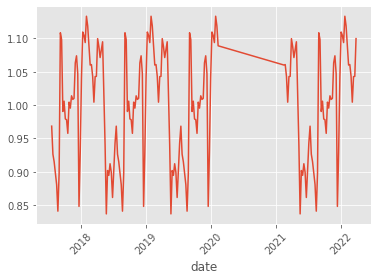

In [72]:
ax = szn_estimates_w_dates.szn_estimate.plot()
ax.xaxis.set_tick_params(rotation=45)

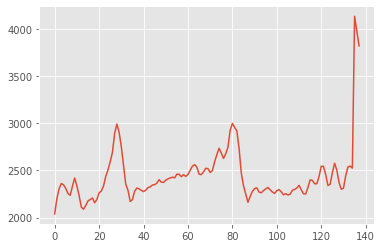

In [158]:
plt.plot(levels_f.get_test_value())

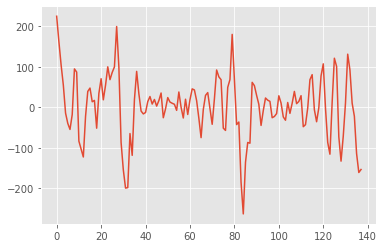

In [159]:
plt.plot(trends_f.get_test_value())

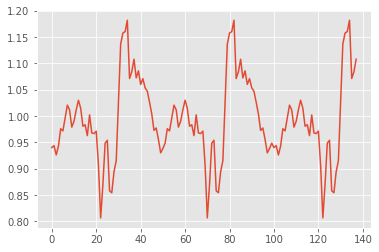

In [161]:
plt.plot(seasons_f.get_test_value())

In [1198]:
ss = pd.DataFrame(zip(zdf.iloc[1:].date, seasons_f.get_test_value()), columns=['date', 'season_effect'])
ss = ss.set_index(ss.date)

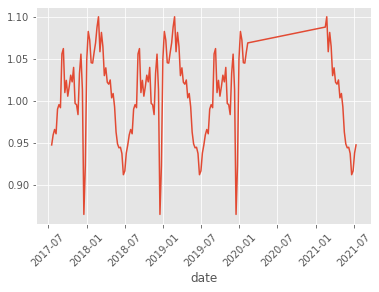

In [1200]:
ax = ss.season_effect.plot()
ax.xaxis.set_tick_params(rotation=45)

In [23]:
res1.shape

(40, 6)

In [34]:
res1['pred_for_date'] = res1.pred_for_date.apply(lambda x: x.date())

f1 = res1.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f1 = f1.set_index(f1.pred_for_date)

f1['error_new'] = f1.pred - f1.total_demand_new
f1['pct_error_new'] = f1.error_new / f1.total_demand_new
f1['abs_error_new'] = f1.error_new.abs()
f1['abs_pct_error_new'] = f1.pct_error_new.abs()

f1['error_old'] = f1.total_demand_new_lag6 - f1.total_demand_new
f1['pct_error_old'] = f1.error_old / f1.total_demand_new
f1['abs_error_old'] = f1.error_old.abs()
f1['abs_pct_error_old'] = f1.pct_error_old.abs()

f1.shape

(40, 26)

In [37]:
f1[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,40.000000,40.000000,40.000000,40.000000
mean,0.088531,0.077489,-0.028849,0.055337
std,0.079032,0.047358,0.115893,0.072530
min,0.009809,0.000219,-0.337572,-0.067237
25%,0.030004,0.048648,-0.066543,0.000858
50%,0.061556,0.071827,-0.019331,0.071827
75%,0.112944,0.094899,0.059954,0.094899
max,0.337572,0.222857,0.138681,0.222857


In [100]:
res_18['pred_for_date'] = res_18.pred_for_date.apply(lambda x: x.date())

f_18 = res_18.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_18 = f_18.set_index(f_18.pred_for_date)

f_18['error_new'] = f_18.pred - f_18.total_demand_new
f_18['pct_error_new'] = f_18.error_new / f_18.total_demand_new
f_18['abs_error_new'] = f_18.error_new.abs()
f_18['abs_pct_error_new'] = f_18.pct_error_new.abs()

f_18['error_old'] = f_18.total_demand_new_lag6 - f_18.total_demand_new
f_18['pct_error_old'] = f_18.error_old / f_18.total_demand_new
f_18['abs_error_old'] = f_18.error_old.abs()
f_18['abs_pct_error_old'] = f_18.pct_error_old.abs()

f_18.shape

(40, 34)

In [125]:
res_2['pred_for_date'] = res_2.pred_for_date.apply(lambda x: x.date())

f_2 = res_2.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_2 = f_2.set_index(f_2.pred_for_date)

f_2['error_new'] = f_2.pred - f_2.total_demand_new
f_2['pct_error_new'] = f_2.error_new / f_2.total_demand_new
f_2['abs_error_new'] = f_2.error_new.abs()
f_2['abs_pct_error_new'] = f_2.pct_error_new.abs()

f_2['error_old'] = f_2.total_demand_new_lag6 - f_2.total_demand_new
f_2['pct_error_old'] = f_2.error_old / f_2.total_demand_new
f_2['abs_error_old'] = f_2.error_old.abs()
f_2['abs_pct_error_old'] = f_2.pct_error_old.abs()

f_2.shape

(40, 34)

In [120]:
res_979['pred_for_date'] = res_979.pred_for_date.apply(lambda x: x.date())

f_979 = res_979.merge(df, left_on=['zone_id', 'pred_for_date'], right_on=['zone_id', 'date'])
f_979 = f_979.set_index(f_979.pred_for_date)

f_979['error_new'] = f_979.pred - f_979.total_demand_new
f_979['pct_error_new'] = f_979.error_new / f_979.total_demand_new
f_979['abs_error_new'] = f_979.error_new.abs()
f_979['abs_pct_error_new'] = f_979.pct_error_new.abs()

f_979['error_old'] = f_979.total_demand_new_lag6 - f_979.total_demand_new
f_979['pct_error_old'] = f_979.error_old / f_979.total_demand_new
f_979['abs_error_old'] = f_979.error_old.abs()
f_979['abs_pct_error_old'] = f_979.pct_error_old.abs()

f_979.shape

(4, 34)

In [101]:
f_18[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,40.000000,40.000000,40.000000,40.000000
mean,0.075001,0.077489,0.016754,0.055337
std,0.047354,0.047358,0.087885,0.072530
min,0.002159,0.000219,-0.167116,-0.067237
25%,0.035874,0.048648,-0.052630,0.000858
50%,0.070538,0.071827,-0.001226,0.071827
75%,0.106740,0.094899,0.097629,0.094899
max,0.167116,0.222857,0.161214,0.222857


In [126]:
f_2[['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,40.000000,40.000000,40.000000,40.000000
mean,0.065501,0.077489,-0.015166,0.055337
std,0.041684,0.047358,0.076825,0.072530
min,0.003648,0.000219,-0.167032,-0.067237
25%,0.030128,0.048648,-0.075626,0.000858
50%,0.066086,0.071827,-0.024305,0.071827
75%,0.089186,0.094899,0.053608,0.094899
max,0.167032,0.222857,0.128020,0.222857


In [146]:
res_2

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season
0,2021-05-10,1,4033.230571,0.6730970258344603,0.9562542499464046,7.486677608097867e-05


In [157]:
res_2

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season
0,2021-05-10,1,3861.550089,0.4901616533203609,0.9999999999999998,9.100920490994391e-07


In [147]:
f_2.loc[f_2.zone_id == 1]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,1,3663.686118,0.3704189850370301,0.9378583763738273,2.2575799925353617e-06,2021-07-26,3898.141821,3663.909110,3738.906556,...,3636.043192,3647.575226,-234.455703,-0.060146,234.455703,0.060146,-262.098629,-0.067237,262.098629,0.067237
2021-06-21,2021-06-21,1,3514.968919,0.3583951992706179,0.9967392659596457,6.353781180747261e-06,2021-06-21,3531.253737,3636.043192,3647.575226,...,3799.919630,3940.326206,-16.284818,-0.004612,16.284818,0.004612,268.665893,0.076082,268.665893,0.076082
2021-05-31,2021-05-31,1,3837.424072,0.3686169629421041,0.99957725310136,2.767565606973364e-05,2021-05-31,3646.368284,3621.476264,3695.795111,...,4078.520633,4049.343485,191.055788,0.052396,191.055788,0.052396,432.152349,0.118516,432.152349,0.118516
2021-05-10,2021-05-10,1,4049.796299,0.519909828109595,0.48112120574418893,2.0587380291332855e-32,2021-05-10,3799.919630,3940.326206,3852.311690,...,4082.580131,4086.456143,249.876669,0.065758,249.876669,0.065758,282.660501,0.074386,282.660501,0.074386


/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


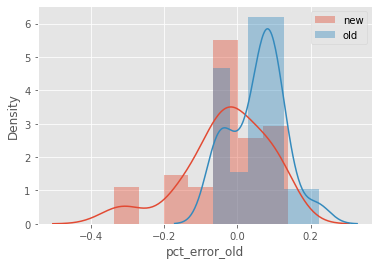

In [39]:
ax = sns.distplot(f1.pct_error_new, label='new')
sns.distplot(f1.pct_error_old, label='old', ax=ax)
ax.legend()

In [40]:
### zone performance

zp = f1.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp.columns = ['_'.join(col).strip() for col in zp.columns.values]

zp['mean_diff'] = zp.abs_pct_error_new_mean - zp.abs_pct_error_old_mean
zp['median_diff'] = zp.abs_pct_error_new_median - zp.abs_pct_error_old_median

zp.reset_index(inplace=True)

zp.head(2)

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.048860,0.06002,0.084055,0.075234,-0.035196,-0.015214
1,13,0.069558,0.06340,0.133793,0.141948,-0.064235,-0.078548


In [102]:
### zone performance

zp_18 = f_18.groupby('zone_id').agg({'abs_pct_error_new': ['mean', 'median'], 'abs_pct_error_old': ['mean', 'median']})
zp_18.columns = ['_'.join(col).strip() for col in zp_18.columns.values]

zp_18['mean_diff'] = zp_18.abs_pct_error_new_mean - zp_18.abs_pct_error_old_mean
zp_18['median_diff'] = zp_18.abs_pct_error_new_median - zp_18.abs_pct_error_old_median

zp_18.reset_index(inplace=True)

zp_18.head(2)

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
0,1,0.045728,0.056271,0.084055,0.075234,-0.038327,-0.018963
1,13,0.047062,0.040339,0.133793,0.141948,-0.086730,-0.101609


In [42]:
zp.sort_values('median_diff')

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
8,979,0.067186,0.036396,0.108775,0.117758,-0.041589,-0.081362
1,13,0.069558,0.063400,0.133793,0.141948,-0.064235,-0.078548
9,1001,0.061659,0.037979,0.086399,0.082613,-0.024740,-0.044634
5,942,0.055458,0.035757,0.079233,0.074767,-0.023775,-0.039010
0,1,0.048860,0.060020,0.084055,0.075234,-0.035196,-0.015214
4,785,0.072524,0.057926,0.064806,0.060270,0.007718,-0.002344
7,973,0.081299,0.096150,0.073722,0.081308,0.007577,0.014842
6,972,0.079824,0.091435,0.071243,0.071914,0.008581,0.019521
3,27,0.156825,0.123158,0.048958,0.056653,0.107867,0.066505
2,18,0.192117,0.222275,0.023904,0.016394,0.168213,0.205881


In [103]:
zp_18.sort_values('median_diff')

,zone_id,abs_pct_error_new_mean,abs_pct_error_new_median,abs_pct_error_old_mean,abs_pct_error_old_median,mean_diff,median_diff
1,13,0.047062,0.040339,0.133793,0.141948,-0.086730,-0.101609
9,1001,0.068567,0.057377,0.086399,0.082613,-0.017832,-0.025236
0,1,0.045728,0.056271,0.084055,0.075234,-0.038327,-0.018963
4,785,0.058228,0.058497,0.064806,0.060270,-0.006578,-0.001773
6,972,0.085056,0.083107,0.071243,0.071914,0.013813,0.011193
5,942,0.079223,0.086279,0.079233,0.074767,-0.000010,0.011512
7,973,0.081674,0.093718,0.073722,0.081308,0.007952,0.012410
3,27,0.061881,0.070641,0.048958,0.056653,0.012923,0.013988
8,979,0.124872,0.151695,0.108775,0.117758,0.016097,0.033936
2,18,0.097718,0.093123,0.023904,0.016394,0.073814,0.076729


In [104]:
f1.loc[f1.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2344.584750,0.7183027611910529,0.0213751966495799,0.0,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-470.512698,-0.167139,470.512698,0.167139,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2500.964704,0.668796170540601,0.023731203089671398,0.0,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-74.198070,-0.028813,74.198070,0.028813,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,2864.895043,0.8070502550666803,0.01829791801622242,0.0,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,118.055695,0.042979,118.055695,0.042979,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,2901.628811,0.784017743670635,0.02159284488940072,0.0,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,84.003005,0.029813,84.003005,0.029813,398.306254,0.141362,398.306254,0.141362


In [105]:
f_18.loc[f_18.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2344.650761,0.7182712859320518,0.021369210749744322,0.0,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-470.446687,-0.167116,470.446687,0.167116,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2500.523865,0.6735785920262594,0.023698043493554474,0.0,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-74.638910,-0.028984,74.638910,0.028984,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,3137.372026,0.4869326992861085,0.999999344974056,0.0,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,390.532678,0.142175,390.532678,0.142175,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,3271.867882,0.47623189225162105,0.9999808519732066,0.0,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,454.242076,0.161214,454.242076,0.161214,398.306254,0.141362,398.306254,0.141362


In [121]:
f_979.loc[f_979.zone_id == 979]

,pred_for_date,zone_id,pred,smoothing_level,smoothing_trend,smoothing_season,date,total_demand_new,total_demand_new_lag1,total_demand_new_lag2,...,total_demand_new_lag6,total_demand_new_lag7,error_new,pct_error_new,abs_error_new,abs_pct_error_new,error_old,pct_error_old,abs_error_old,abs_pct_error_old
pred_for_date,,,,,,,,,,,,,,,,,,,,,
2021-07-26,2021-07-26,979,2694.352380,0.4280264571088128,0.8356378362755952,1.379109197721045e-05,2021-07-26,2815.097448,2729.519799,2632.201997,...,2657.244808,2693.665182,-120.745068,-0.042892,120.745068,0.042892,-157.852640,-0.056074,157.852640,0.056074
2021-06-21,2021-06-21,979,2541.864616,0.4286242228133984,0.9247243010826816,2.438283183931437e-05,2021-06-21,2575.162775,2657.244808,2693.665182,...,2817.625806,2962.656039,-33.298159,-0.012931,33.298159,0.012931,242.463031,0.094154,242.463031,0.094154
2021-05-31,2021-05-31,979,2904.077197,0.7416090407942576,0.23161838632312984,8.377424588706081e-05,2021-05-31,2746.839348,2739.592759,2746.861242,...,3141.039904,3115.021186,157.237849,0.057243,157.237849,0.057243,394.200555,0.143511,394.200555,0.143511
2021-05-10,2021-05-10,979,3154.889655,0.7684749021387602,0.20016980332303683,5.5488076952358854e-05,2021-05-10,2817.625806,2962.656039,2963.606841,...,3215.932060,3226.790095,337.263849,0.119698,337.263849,0.119698,398.306254,0.141362,398.306254,0.141362


In [114]:
f_18.loc[f_18.smoothing_season == 0.0][['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,20.000000,20.000000,20.000000,20.000000
mean,0.091855,0.086404,0.052988,0.065170
std,0.048083,0.030613,0.090763,0.065766
min,0.002159,0.042229,-0.167116,-0.059860
25%,0.053563,0.058913,-0.025090,0.046966
50%,0.100962,0.089845,0.093718,0.089845
75%,0.132766,0.101066,0.121350,0.101066
max,0.167116,0.143511,0.161214,0.143511


In [115]:
f_18.loc[f_18.smoothing_season != 0.0][['abs_pct_error_new', 'abs_pct_error_old', 'pct_error_new', 'pct_error_old']].describe()

,abs_pct_error_new,abs_pct_error_old,pct_error_new,pct_error_old
count,20.000000,20.000000,20.000000,20.000000
mean,0.058147,0.068574,-0.019480,0.045505
std,0.041143,0.059154,0.069658,0.079179
min,0.004612,0.000219,-0.167032,-0.067237
25%,0.027875,0.030732,-0.068527,-0.006940
50%,0.062952,0.064922,-0.027404,0.052281
75%,0.079486,0.074810,0.016730,0.074810
max,0.167032,0.222857,0.102730,0.222857


In [109]:
f_18[['zone_id', 'date', 'smoothing_level', 'smoothing_trend', 'smoothing_season', 'total_demand_new', 'pred', 'total_demand_new_lag6', 'pct_error_new', 'pct_error_old', 'error_new', 'error_old']].sort_values(['zone_id', 'pred_for_date'])

,zone_id,date,smoothing_level,smoothing_trend,smoothing_season,total_demand_new,pred,total_demand_new_lag6,pct_error_new,pct_error_old,error_new,error_old
pred_for_date,,,,,,,,,,,,
2021-05-10,1,2021-05-10,0.519909828109595,0.48112120574418893,2.0587380291332855e-32,3799.919630,4049.796299,4082.580131,0.065758,0.074386,249.876669,282.660501
2021-05-31,1,2021-05-31,0.3686169629421041,0.99957725310136,2.767565606973364e-05,3646.368284,3837.424072,4078.520633,0.052396,0.118516,191.055788,432.152349
2021-06-21,1,2021-06-21,0.3583951992706179,0.9967392659596457,6.353781180747261e-06,3531.253737,3514.968919,3799.919630,-0.004612,0.076082,-16.284818,268.665893
2021-07-26,1,2021-07-26,0.3704189850370301,0.9378583763738273,2.2575799925353617e-06,3898.141821,3663.686118,3636.043192,-0.060146,-0.067237,-234.455703,-262.098629
2021-05-10,13,2021-05-10,0.7696821290210248,0.19804270518386838,9.069323276782556e-05,848.401123,911.745389,1028.345999,0.074663,0.212099,63.344266,179.944876
2021-05-31,13,2021-05-31,0.749692586490308,0.2163929474579398,2.2256166426181486e-05,825.454785,910.253574,1009.413478,0.102730,0.222857,84.798788,183.958692
2021-06-21,13,2021-06-21,0.787173878272498,0.18242723911304506,1.6988797915875554e-06,791.569353,795.401840,848.401123,0.004842,0.071796,3.832487,56.831771
2021-07-26,13,2021-07-26,0.7565958619756966,0.20571542355929504,5.566798452302579e-05,822.498868,817.551517,799.124850,-0.006015,-0.028418,-4.947351,-23.374018
2021-05-10,18,2021-05-10,0.740489583130101,0.3137934964537862,0.00019216976329419988,1360.898222,1246.225216,1446.099833,-0.084263,0.062607,-114.673006,85.201611


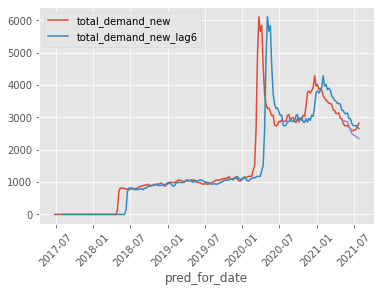

In [106]:
ax = df.loc[(df.zone_id == 979)
#             &(df.date <= f_date + timedelta(weeks=HORIZON))
           ][['total_demand_new', 'total_demand_new_lag6']].plot()

f1.loc[f1.zone_id == 979].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

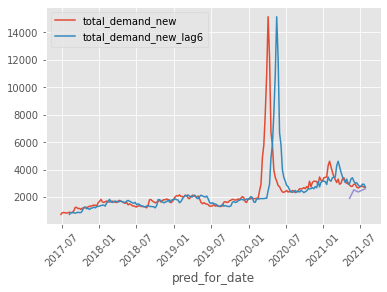

In [48]:
ax = df.loc[(df.zone_id == 27)
#             &(df.date <= f_date + timedelta(weeks=HORIZON))
           ][['total_demand_new', 'total_demand_new_lag6']].plot()

f1.loc[f1.zone_id == 27].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

<AxesSubplot:xlabel='date_idx'>

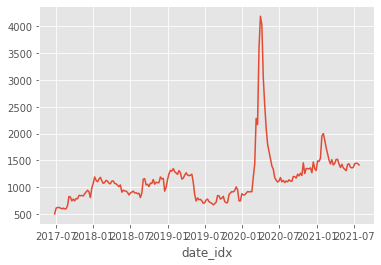

In [49]:
df.loc[df.zone_id == 18].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

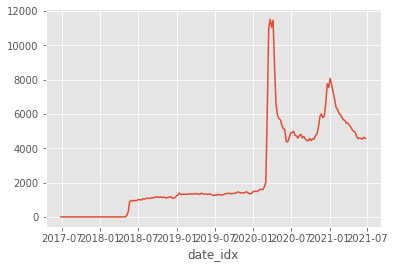

In [431]:
df.loc[df.zone_id == 983].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

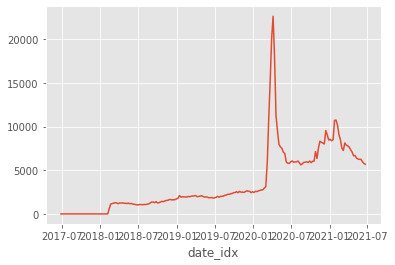

In [433]:
df.loc[df.zone_id == 861].total_demand_new.plot()

<AxesSubplot:xlabel='date_idx'>

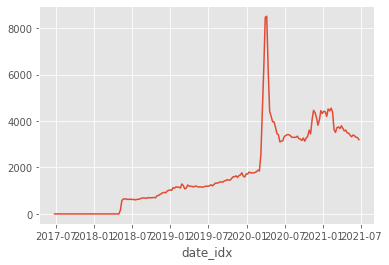

In [434]:
df.loc[df.zone_id == 989].total_demand_new.plot()

In [ ]:
# btm 3 (1001, 943, 787)

In [736]:
f4.loc[f4.zone_id == 974][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,4635.691899,4425.085032,4783.576204
2021-05-31,2021-05-31,4783.576204,4487.976940,4901.835912
2021-05-10,2021-05-10,4901.835912,5107.128759,5314.633336
2021-04-19,2021-04-19,5314.633336,5741.627466,5328.496810
2020-01-27,2020-01-27,2734.623225,2729.935405,2688.233743
2020-01-06,2020-01-06,2688.233743,2859.332854,2290.397509
2019-12-16,2019-12-16,2290.397509,2091.314580,2571.524910


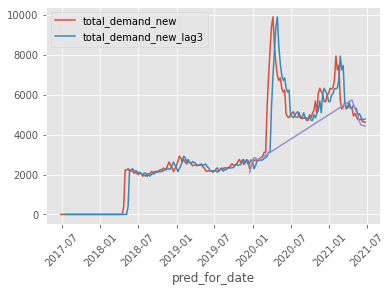

In [732]:
ax = df.loc[df.zone_id == 974][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 974].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [733]:
f4.loc[f4.zone_id == 972][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,6428.423384,5920.677019,6512.364852
2021-05-31,2021-05-31,6512.364852,6308.358613,6642.146212
2021-05-10,2021-05-10,6642.146212,6914.151477,7097.163660
2021-04-19,2021-04-19,7097.163660,7147.823689,7299.164351
2020-01-27,2020-01-27,3031.638005,2889.873568,2959.022573
2020-01-06,2020-01-06,2959.022573,3161.603770,2606.750241
2019-12-16,2019-12-16,2606.750241,2623.576807,2909.170012


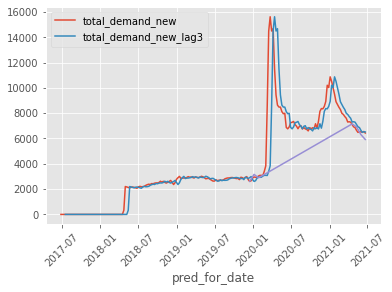

In [734]:
ax = df.loc[df.zone_id == 972][['total_demand_new', 'total_demand_new_lag3']].plot()

f4.loc[f4.zone_id == 972].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

In [509]:
f1.loc[f1.zone_id == 787][['date', 'total_demand_new', 'pred', 'total_demand_new_lag3']]

,date,total_demand_new,pred,total_demand_new_lag3
pred_for_date,,,,
2021-06-21,2021-06-21,3004.375691,8.526171e+02,3265.079548
2021-05-31,2021-05-31,3265.079548,-1.013012e+02,3259.695788
2021-05-10,2021-05-10,3259.695788,-3.164240e+03,3560.283871
2021-04-19,2021-04-19,3560.283871,1.960622e+06,3637.874023
2020-01-27,2020-01-27,1461.759721,1.494049e+03,1335.743291
2020-01-06,2020-01-06,1335.743291,1.524767e+03,1263.330682
2019-12-16,2019-12-16,1263.330682,1.314865e+03,1253.453050


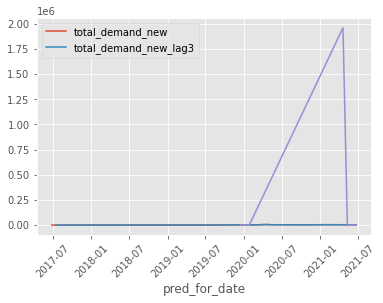

In [510]:
ax = df.loc[df.zone_id == 787][['total_demand_new', 'total_demand_new_lag3']].plot()

f1.loc[f1.zone_id == 787].pred.plot(ax=ax)

ax.xaxis.set_tick_params(rotation=45)

/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sorenzeliger/.pyenv/versions/3.8.6/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


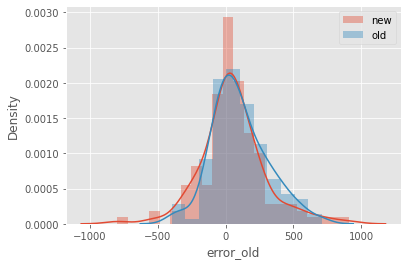

In [737]:
ax = sns.distplot(f4.error_new, label='new')
sns.distplot(f4.error_old, label='old')

ax.legend(loc='best')